In [45]:
import json
import numpy as np
from pandas.io.json import json_normalize

import os
import glob as gb
import tensorflow as tf

from sklearn.model_selection import train_test_split
import keras 
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM , Flatten , CuDNNLSTM , GRU
from keras.layers import Dropout
import keras

from keras import callbacks
from keras.callbacks import  CSVLogger


# Model Evaluations
from sklearn import metrics
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc


In [46]:
def load_file(filepath,i):
    with open(filepath) as f:
        data = json.load(f)
    imu = data['imu']['data']
    emg = data['emg']['data']
    emg = np.array(emg)
    imu = np.array(imu)
    imu_gyr = np.array([(e['gyroscope']) for e in imu])
    imu_acc = np.array([(e['acceleration']) for e in imu])
    imu_orn = np.array([(e['orientation']) for e in imu])
    #timestamp = [i]
    #timestamp = np.repeat(timestamp, 400, axis=None)
    #timestamp= timestamp.reshape(400,1)
    dataset = tf.concat([emg, imu_gyr, imu_acc, imu_orn], axis=1, name='concat')
    dataset = np.array(dataset)
    return dataset

In [47]:
data_path = '../input/emgimu/An-EMG-and-IMU-Dataset-for-the-Italian-Sign-Language-Alphabet-master/Dataset/'

In [48]:
# For Files Data
X = []
y = []
i=0
for folder in  os.listdir(data_path) : 
    j=0
    files = gb.glob(pathname= str( data_path  + folder + '/*.json'))
    for file in files: 
        data = load_file(file,j)
        X.append(data)
        y.append(i)
        j+=1
    i+=1

print(f'we have {len(X)} items in X ')

we have 780 items in X 


In [49]:
X = np.array(X)
y = np.array(y)

In [50]:
from sklearn.utils import shuffle
X, y = shuffle(X, y, random_state=20)


In [51]:
print('X shape is : ' , X.shape)
print('y shape is : ' , y.shape)

X shape is :  (780, 400, 18)
y shape is :  (780,)


In [52]:
mapping = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25}

In [53]:
def getcode(n) : 
    for x , y in mapping.items() : 
        if n == y : 
            return x

# Building Model with files

In [54]:
X_train_f, X_split_f, y_train_f, y_split_f = train_test_split(X, y, test_size=0.30, random_state=42)
X_test_f, X_valid_f, y_test_f, y_valid_f = train_test_split(X_split_f, y_split_f, test_size=0.50, random_state=42)

In [55]:
# X_train_f = X_train_f.reshape(X_train_f.shape[0] , X_train_f.shape[1]*X_train_f.shape[2])
# X_valid_f = X_valid_f.reshape(X_valid_f.shape[0] , X_valid_f.shape[1]*X_valid_f.shape[2])
# X_test_f = X_test_f.reshape(X_test_f.shape[0] , X_test_f.shape[1]*X_test_f.shape[2])

X_train_f = X_train_f.reshape(len(X_train_f), X_train_f.shape[1],18)
X_valid_f = X_valid_f.reshape(len(X_test_f), X_test_f.shape[1],18)
X_test_f = X_test_f.reshape(len(X_valid_f), X_valid_f.shape[1],18)

In [56]:
print(X_train_f.shape)
print(X_test_f.shape)

(546, 400, 18)
(117, 400, 18)


In [57]:
y_train_f = to_categorical(y_train_f)
y_test_f=to_categorical(y_test_f)
y_valid_f=to_categorical(y_valid_f)

In [110]:
from keras.layers import Conv1D, MaxPooling1D, CuDNNLSTM, Dropout, Flatten, GRU

model = keras.models.Sequential([
    
        GRU(units=100, return_sequences=True, input_shape =(400,18), activation='tanh'),
        Dropout(0.2),
        GRU(units=50, return_sequences=True, activation='tanh'),
        Dropout(0.2),
        GRU(units=50, return_sequences=True, activation='tanh'),
        Dropout(0.2),
#         GRU(units=50, activation='tanh'),
#         Dropout(0.2),
        
        Flatten(),
        Dense(26,activation='softmax') ,    
        ])


In [111]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_29 (GRU)                 (None, 400, 100)          36000     
_________________________________________________________________
dropout_31 (Dropout)         (None, 400, 100)          0         
_________________________________________________________________
gru_30 (GRU)                 (None, 400, 50)           22800     
_________________________________________________________________
dropout_32 (Dropout)         (None, 400, 50)           0         
_________________________________________________________________
gru_31 (GRU)                 (None, 400, 50)           15300     
_________________________________________________________________
dropout_33 (Dropout)         (None, 400, 50)           0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 20000)           

In [112]:
import tensorflow as tf

# try using different optimizers and different optimizer configs
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath="./checkpoint-{epoch:02d}.hdf5", verbose=1, save_best_only=True, monitor='val_acc',mode='max')
csv_logger = CSVLogger('training_set_iranalysis3.csv',separator=',', append=False)
history = model.fit(X_train_f, y_train_f, batch_size=128, epochs=100, validation_data=(X_valid_f, y_valid_f),callbacks=[es,checkpointer,csv_logger])
model.save("./lstm.hdf5")

Epoch 1/100
5/5 [==============================] - 5s 268ms/step - loss: 2.6464 - accuracy: 0.2747 - val_loss: 1.3977 - val_accuracy: 0.6068
Epoch 2/100
5/5 [==============================] - 0s 61ms/step - loss: 0.7531 - accuracy: 0.7949 - val_loss: 0.7110 - val_accuracy: 0.7949
Epoch 3/100
5/5 [==============================] - 0s 59ms/step - loss: 0.3218 - accuracy: 0.9176 - val_loss: 0.6351 - val_accuracy: 0.7863
Epoch 4/100
5/5 [==============================] - 0s 60ms/step - loss: 0.1191 - accuracy: 0.9799 - val_loss: 0.5699 - val_accuracy: 0.8462
Epoch 5/100
5/5 [==============================] - 0s 60ms/step - loss: 0.0477 - accuracy: 0.9963 - val_loss: 0.5637 - val_accuracy: 0.8718
Epoch 6/100
5/5 [==============================] - 0s 59ms/step - loss: 0.0270 - accuracy: 0.9982 - val_loss: 0.5377 - val_accuracy: 0.8803
Epoch 7/100
5/5 [==============================] - 0s 58ms/step - loss: 0.0094 - accuracy: 1.0000 - val_loss: 0.5110 - val_accuracy: 0.8889
Epoch 8/100
5/5 [==

In [113]:
test_results = model.evaluate(X_test_f, y_test_f, verbose=1)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]*100}%')

4/4 [==============================] - 0s 33ms/step - loss: 0.5069 - accuracy: 0.8803
Test results - Loss: 0.5068957805633545 - Accuracy: 88.034188747406%


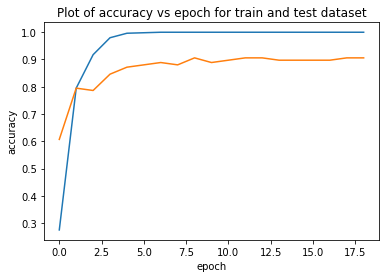

In [114]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Plot of accuracy vs epoch for train and test dataset")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

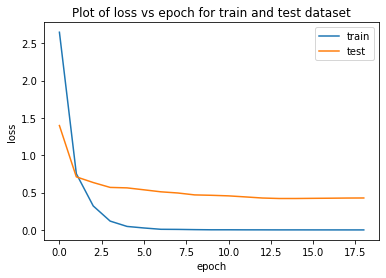

In [115]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Plot of loss vs epoch for train and test dataset")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()